找到 38 个CSV文件，将进行处理...
成功预处理 38 场洪水事件。

洪水分类阈值 (基于观测洪峰 m3/s):
  小洪水 Peak_obs <= 654.57
  中洪水 654.57 < Peak_obs <= 1240.64
  大洪水 Peak_obs > 1240.64

各类别洪水事件数量:
  Small 洪水: 13 场
  Medium 洪水: 12 场
  Large 洪水: 13 场

--- 正在处理类别: Small 洪水 (13 场) ---
  类别 small 的单位线长度 (n_uh_cat): 49
  使用权重: 平滑因子=0.1, 单峰惩罚因子=20000.0
  类别 small 单位线优化成功


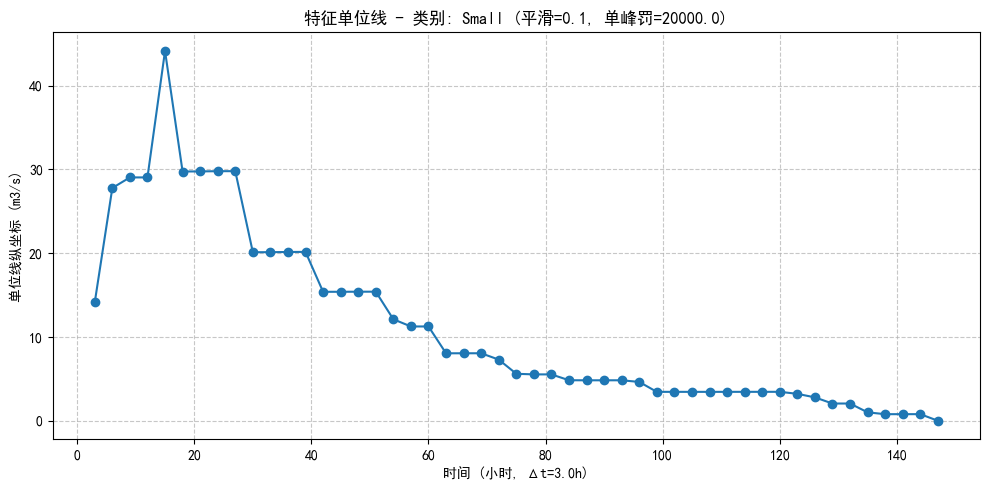

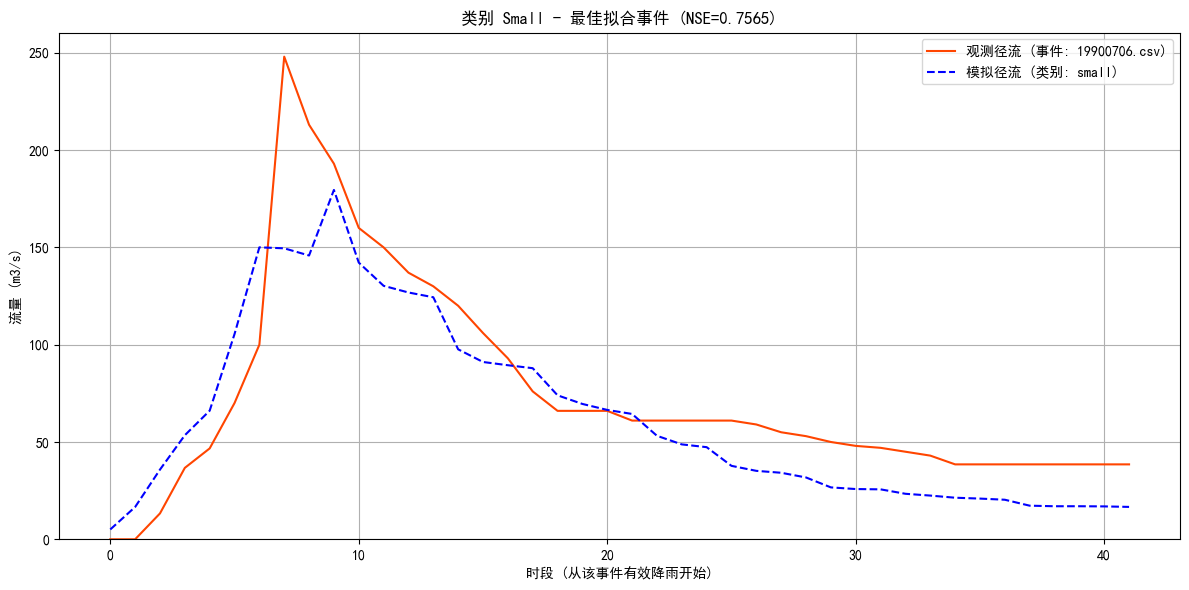


--- 正在处理类别: Medium 洪水 (12 场) ---
  类别 medium 的单位线长度 (n_uh_cat): 51
  使用权重: 平滑因子=0.5, 单峰惩罚因子=500.0
  类别 medium 单位线优化成功


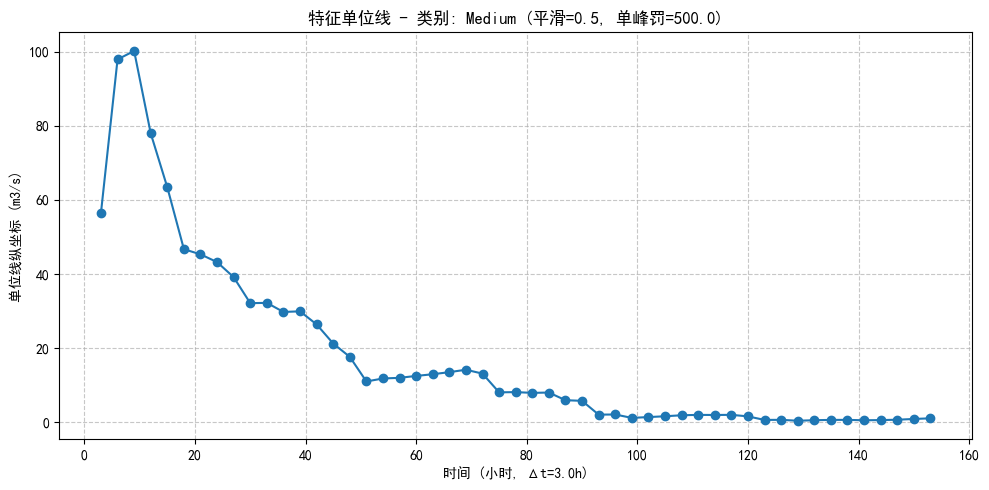

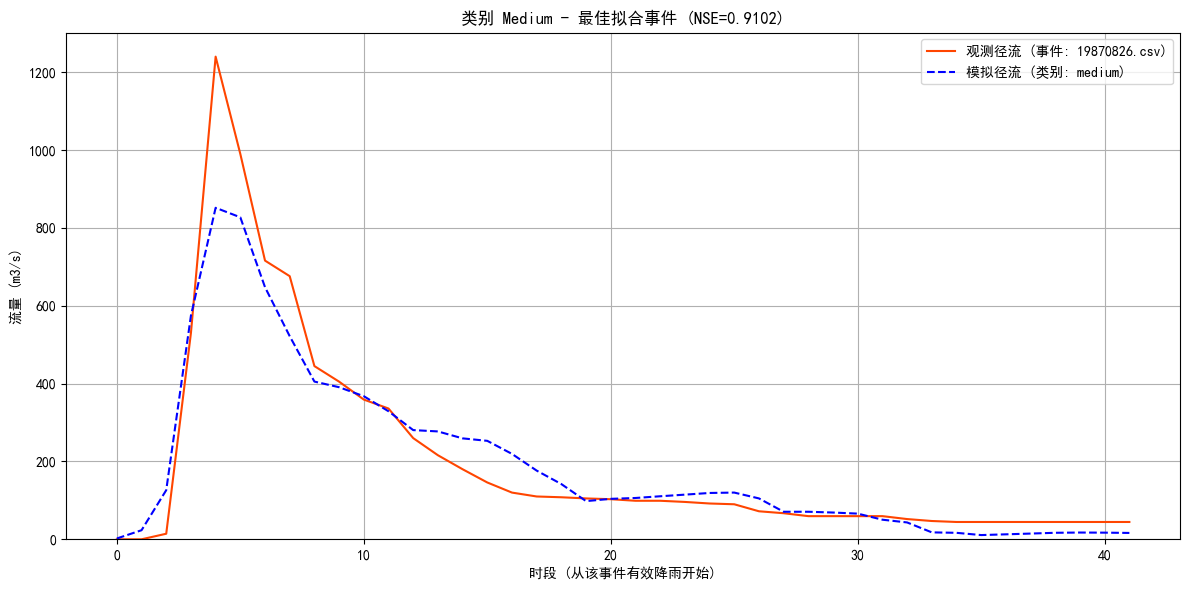


--- 正在处理类别: Large 洪水 (13 场) ---
  类别 large 的单位线长度 (n_uh_cat): 55
  使用权重: 平滑因子=1.0, 单峰惩罚因子=1000.0
  类别 large 单位线优化成功


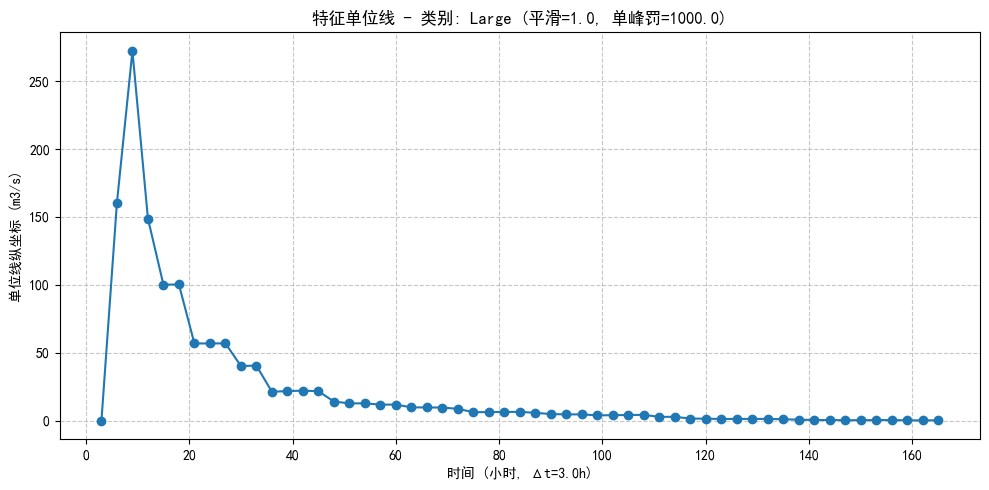

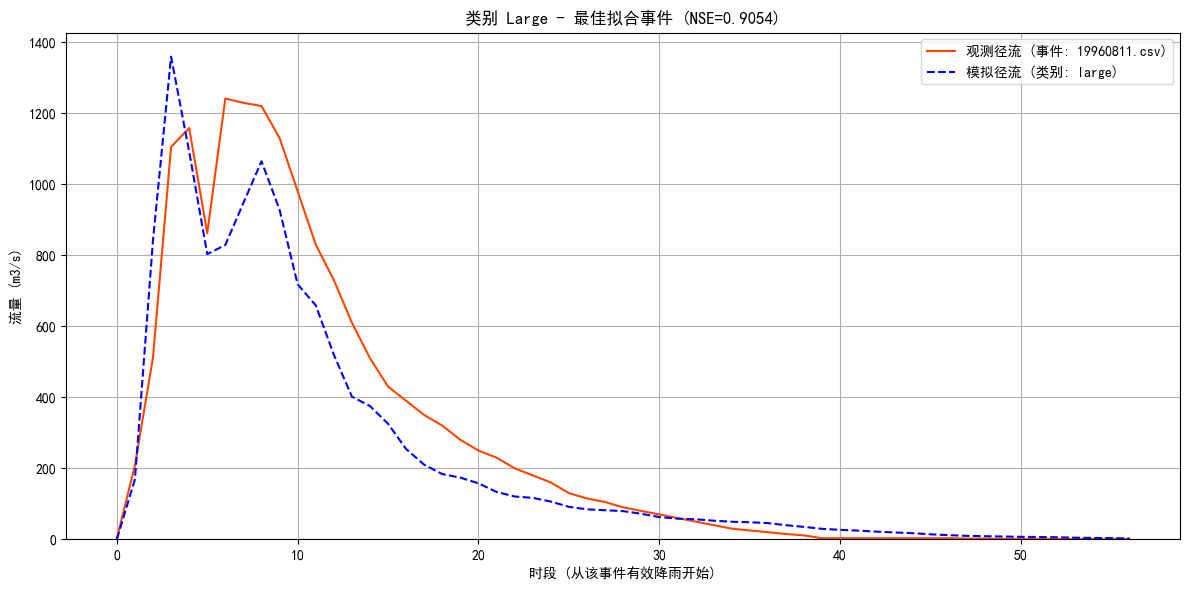


--- 所有类别优化总结 ---
类别: Small, 事件数: 13, 状态: optimized
  单位线长度: 49, 平均NSE: -9.6261, NSE中位数: -0.0287
类别: Medium, 事件数: 12, 状态: optimized
  单位线长度: 51, 平均NSE: 0.5529, NSE中位数: 0.5764
类别: Large, 事件数: 13, 状态: optimized
  单位线长度: 55, 平均NSE: 0.5567, NSE中位数: 0.7854


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.font_manager import FontProperties
import os

# --- 配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("中文字体 SimHei 未找到，请确保已安装或修改字体设置。")

R_UH = 10.0
DELTA_T_HOURS = 3.0
delta_t_seconds = DELTA_T_HOURS * 3600.0

# --- 辅助函数：数据预处理 (与之前相同) ---
def preprocess_single_event_data(csv_filepath):
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None
        for enc in encodings_to_try:
            try:
                df = pd.read_csv(csv_filepath, encoding=enc)
                break
            except UnicodeDecodeError:
                continue
        if df is None: return None
    except Exception: return None

    time_col = '时间'
    net_rain_col = '泰森多边形面雨量'
    direct_runoff_col = '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None

    df[net_rain_col] = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0)
    df[direct_runoff_col] = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0)
    net_rain_full_event = df[net_rain_col].values
    direct_runoff_obs_full_event = df[direct_runoff_col].values

    first_rain_idx = 0
    has_effective_rain = False
    for i, r_val in enumerate(net_rain_full_event):
        if r_val > 1e-6:
            first_rain_idx = i
            has_effective_rain = True
            break
    if not has_effective_rain: return None

    last_rain_idx = len(net_rain_full_event) - 1
    for i in range(len(net_rain_full_event) - 1, first_rain_idx - 1, -1):
        if net_rain_full_event[i] > 1e-6:
            last_rain_idx = i
            break
    
    P_eff_event = net_rain_full_event[first_rain_idx : last_rain_idx + 1]
    m_eff_event = len(P_eff_event)
    if m_eff_event == 0: return None

    Q_obs_eff_event = direct_runoff_obs_full_event[first_rain_idx:]
    l_obs_eff_event = len(Q_obs_eff_event)
    n_event_specific = l_obs_eff_event - m_eff_event + 1
    if n_event_specific <= 0: return None
        
    return {
        "P_eff": P_eff_event, "Q_obs_eff": Q_obs_eff_event,
        "m_eff": m_eff_event, "l_obs_eff": l_obs_eff_event,
        "n_specific": n_event_specific, "filepath": csv_filepath,
        "peak_obs": np.max(Q_obs_eff_event) if len(Q_obs_eff_event) > 0 else 0,
        "total_p_eff": np.sum(P_eff_event)
    }

# --- 核心计算函数 (与之前相同) ---
def convolve_uh(P, U, R_UH_val):
    m_p = len(P)
    n_u = len(U)
    len_q = m_p + n_u - 1
    if len_q < 0: len_q = 0 
    Q_sim = np.zeros(len_q)
    P_normalized = P / R_UH_val
    for i in range(m_p):
        if P_normalized[i] > 1e-9:
            for k in range(n_u):
                if (i + k) < len_q:
                    Q_sim[i + k] += P_normalized[i] * U[k]
    return Q_sim

def objective_function_multi_event(U_params, list_of_event_data_for_opt, R_UH_val, 
                                   lambda_smooth, lambda_peak_violation, apply_peak_penalty_flag,
                                   common_n_uh_for_category):
    total_fit_loss = 0
    if len(U_params) != common_n_uh_for_category: return 1e18 
    for event_data in list_of_event_data_for_opt:
        P_event = event_data["P_eff"]
        Q_event_obs_for_opt = event_data["Q_obs_for_opt"]
        Q_sim_full_event = convolve_uh(P_event, U_params, R_UH_val)
        len_obs_event = len(Q_event_obs_for_opt)
        Q_sim_compare_event = Q_sim_full_event[:len_obs_event]
        total_fit_loss += np.sum((Q_sim_compare_event - Q_event_obs_for_opt)**2)
    loss_smooth_val = 0
    if len(U_params) > 1: loss_smooth_val = np.sum(np.diff(U_params)**2)
    peak_violation_penalty_val = 0
    if apply_peak_penalty_flag and len(U_params) > 2:
        actual_k_peak = np.argmax(U_params)
        for j in range(actual_k_peak):
            if U_params[j+1] < U_params[j] - 1e-6: peak_violation_penalty_val += (U_params[j] - U_params[j+1])**2
        for j in range(actual_k_peak, len(U_params) - 1):
            if U_params[j+1] > U_params[j] + 1e-6: peak_violation_penalty_val += (U_params[j+1] - U_params[j])**2
    return total_fit_loss + lambda_smooth * loss_smooth_val + lambda_peak_violation * peak_violation_penalty_val

# --- 主程序 ---
data_folder = "data_source/" 
csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
print(f"找到 {len(csv_files)} 个CSV文件，将进行处理...")

all_events_processed_data = []
for csv_file in csv_files:
    event_data = preprocess_single_event_data(csv_file)
    if event_data:
        all_events_processed_data.append(event_data)

if not all_events_processed_data:
    print("没有成功处理任何洪水事件数据。程序退出。")
    exit()
print(f"成功预处理 {len(all_events_processed_data)} 场洪水事件。")

# 1. 计算分类指标
event_peaks = [data['peak_obs'] for data in all_events_processed_data if data['peak_obs'] > 0]
if not event_peaks:
    print("未能从任何事件中提取到有效的洪峰值，无法进行分类。")
    exit()

# 2. 确定分类阈值
threshold_low = np.percentile(event_peaks, 33.3)
threshold_high = np.percentile(event_peaks, 66.6)
print(f"\n洪水分类阈值 (基于观测洪峰 m3/s):") # 修改Y轴单位
print(f"  小洪水 Peak_obs <= {threshold_low:.2f}")
print(f"  中洪水 {threshold_low:.2f} < Peak_obs <= {threshold_high:.2f}")
print(f"  大洪水 Peak_obs > {threshold_high:.2f}")

# 3. 对洪水事件进行分类
categorized_events = {'small': [], 'medium': [], 'large': []}
for event_data in all_events_processed_data:
    peak = event_data['peak_obs']
    if peak <= threshold_low:
        categorized_events['small'].append(event_data)
    elif peak <= threshold_high:
        categorized_events['medium'].append(event_data)
    else:
        categorized_events['large'].append(event_data)

print("\n各类别洪水事件数量:")
for category, events in categorized_events.items():
    print(f"  {category.capitalize()} 洪水: {len(events)} 场")

# 4. 为每个类别推求特征单位线并评估
all_category_results_summary = {}
category_weights = {
    'small':  {'smoothing_factor': 0.1, 'peak_violation_weight': 20000.0},
    'medium': {'smoothing_factor': 0.5, 'peak_violation_weight': 500.0},
    'large':  {'smoothing_factor': 1.0, 'peak_violation_weight': 1000.0}
}

for category_name, events_in_category in categorized_events.items():
    print(f"\n--- 正在处理类别: {category_name.capitalize()} 洪水 ({len(events_in_category)} 场) ---")
    if len(events_in_category) < 3: 
        print(f"类别 {category_name} 事件数量过少，跳过优化。")
        all_category_results_summary[category_name] = {"status": "skipped_due_to_low_count", "n_events": len(events_in_category)}
        continue

    # a & b. 准备数据
    n_specific_cat = [data["n_specific"] for data in events_in_category if data["n_specific"] > 0]
    if not n_specific_cat:
        print(f"类别 {category_name} 未能确定有效的n_specific。跳过。")
        all_category_results_summary[category_name] = {"status": "skipped_no_valid_n_specific", "n_events": len(events_in_category)}
        continue
    common_n_uh_cat = int(np.max(n_specific_cat))
    if common_n_uh_cat <= 1: common_n_uh_cat = max(3, common_n_uh_cat if common_n_uh_cat > 0 else 3)
    print(f"  类别 {category_name} 的单位线长度 (n_uh_cat): {common_n_uh_cat}")
    
    list_of_event_data_for_opt_cat = []
    for event_data in events_in_category:
        P_eff_cat = event_data["P_eff"]
        Q_obs_eff_cat = event_data["Q_obs_eff"]
        m_eff_cat = event_data["m_eff"]
        target_q_len_cat = m_eff_cat + common_n_uh_cat - 1
        if target_q_len_cat < 0: target_q_len_cat = 0
        Q_obs_for_opt_cat_event = np.zeros(target_q_len_cat)
        len_to_copy_cat = min(len(Q_obs_eff_cat), target_q_len_cat)
        Q_obs_for_opt_cat_event[:len_to_copy_cat] = Q_obs_eff_cat[:len_to_copy_cat]
        list_of_event_data_for_opt_cat.append({"P_eff": P_eff_cat, "Q_obs_for_opt": Q_obs_for_opt_cat_event, "filepath": event_data["filepath"]})

    # c. 设置优化参数
    U_initial_guess_cat = np.zeros(common_n_uh_cat)
    bounds_cat = [(0, None) for _ in range(common_n_uh_cat)]
    weights_for_this_category = category_weights.get(category_name, {'smoothing_factor': 0.1, 'peak_violation_weight': 100.0})
    smoothing_factor_cat = weights_for_this_category['smoothing_factor']
    peak_violation_weight_cat = weights_for_this_category['peak_violation_weight']
    apply_peak_penalty_cat = common_n_uh_cat > 2
    print(f"  使用权重: 平滑因子={smoothing_factor_cat}, 单峰惩罚因子={peak_violation_weight_cat if apply_peak_penalty_cat else 'N/A'}")

    # d. 执行优化
    result_cat_uh = minimize(objective_function_multi_event, U_initial_guess_cat, args=(list_of_event_data_for_opt_cat, R_UH, smoothing_factor_cat, peak_violation_weight_cat, apply_peak_penalty_cat, common_n_uh_cat), method='L-BFGS-B', bounds=bounds_cat, options={'disp': False, 'maxiter': 500, 'ftol': 1e-8, 'gtol': 1e-6})
    U_optimized_cat = result_cat_uh.x if (result_cat_uh.success or result_cat_uh.status in [0,2]) else U_initial_guess_cat
    print(f"  类别 {category_name} 单位线优化{'成功' if (result_cat_uh.success or result_cat_uh.status in [0,2]) else '可能未收敛'}")

    # e. 绘制该类别的特征单位线
    time_axis_uh_cat = np.arange(1, common_n_uh_cat + 1) * DELTA_T_HOURS
    plt.figure(figsize=(10, 5)) # 调整尺寸以提供更多空间
    plt.plot(time_axis_uh_cat, U_optimized_cat, marker='o', linestyle='-')
    plt.title(f'特征单位线 - 类别: {category_name.capitalize()} (平滑={smoothing_factor_cat}, 单峰罚={peak_violation_weight_cat if apply_peak_penalty_cat else "N/A"})')
    plt.xlabel(f'时间 (小时, Δt={DELTA_T_HOURS}h)')
    plt.ylabel('单位线纵坐标 (m3/s)') # 修改Y轴单位标签
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout() # 自动调整布局
    plt.show()

    # f. 评估该类别单位线在其类别内的表现
    category_event_analysis = []
    for event_data in events_in_category:
        P_event = event_data["P_eff"]
        Q_obs_event_full = event_data["Q_obs_eff"]
        event_filename = os.path.basename(event_data["filepath"])
        Q_sim_event_full = convolve_uh(P_event, U_optimized_cat, R_UH)
        Q_sim_event_compare = Q_sim_event_full[:len(Q_obs_event_full)]
        
        # ... (与之前版本相同的误差指标计算逻辑) ...
        current_event_analysis = {"filename": event_filename, "nse": np.nan, "peak_obs_m3s": np.max(Q_obs_event_full) if len(Q_obs_event_full) > 0 else 0}
        if len(Q_obs_event_full) > 0 and len(Q_sim_event_compare) == len(Q_obs_event_full):
            mean_obs = np.mean(Q_obs_event_full)
            den_nse = np.sum((Q_obs_event_full - mean_obs)**2)
            if den_nse == 0: nse_event = 1.0 if np.allclose(Q_sim_event_compare, Q_obs_event_full) else -np.inf
            else: nse_event = 1 - (np.sum((Q_obs_event_full - Q_sim_event_compare)**2) / den_nse)
            current_event_analysis["nse"] = nse_event
        category_event_analysis.append(current_event_analysis)
        
    # --- 找到该类别中NSE最高的事件并绘图 ---
    if category_event_analysis:
        # 筛选掉无效NSE值，然后找到最大值
        valid_events_for_plot = [res for res in category_event_analysis if pd.notna(res['nse']) and np.isfinite(res['nse'])]
        if valid_events_for_plot:
            best_fit_event_info = max(valid_events_for_plot, key=lambda x: x['nse'])
            best_fit_filename = best_fit_event_info['filename']
            best_fit_nse = best_fit_event_info['nse']
            
            # 从原始数据中找到这个最佳拟合事件的数据
            best_event_data = next((data for data in events_in_category if os.path.basename(data["filepath"]) == best_fit_filename), None)
            
            if best_event_data:
                P_best = best_event_data["P_eff"]
                Q_obs_best = best_event_data["Q_obs_eff"]
                
                Q_sim_best_full = convolve_uh(P_best, U_optimized_cat, R_UH)
                Q_sim_best_plot = Q_sim_best_full[:len(Q_obs_best)]

                plt.figure(figsize=(12, 6))
                plt.plot(np.arange(len(Q_obs_best)), Q_obs_best, label=f'观测径流 (事件: {best_fit_filename})', color='orangered')
                plt.plot(np.arange(len(Q_sim_best_plot)), Q_sim_best_plot, label=f'模拟径流 (类别: {category_name})', color='blue', linestyle='--')
                plt.title(f'类别 {category_name.capitalize()} - 最佳拟合事件 (NSE={best_fit_nse:.4f})')
                plt.xlabel('时段 (从该事件有效降雨开始)')
                plt.ylabel('流量 (m3/s)') # 修改Y轴单位标签
                plt.legend()
                plt.grid(True)
                plt.ylim(bottom=0)
                plt.tight_layout() # 自动调整布局
                plt.show()

    # 存储总结结果 (这部分逻辑保持不变)
    valid_nses_cat = [res['nse'] for res in category_event_analysis if pd.notna(res['nse']) and np.isfinite(res['nse'])]
    all_category_results_summary[category_name] = {
        "status": "optimized", "n_events": len(events_in_category),
        "common_n_uh_cat": common_n_uh_cat, "U_optimized": U_optimized_cat.tolist(),
        "avg_nse": np.mean(valid_nses_cat) if valid_nses_cat else np.nan,
        "median_nse": np.median(valid_nses_cat) if valid_nses_cat else np.nan
    }


print("\n--- 所有类别优化总结 ---")
for cat_name, summary in all_category_results_summary.items():
    print(f"类别: {cat_name.capitalize()}, 事件数: {summary['n_events']}, 状态: {summary['status']}")
    if summary['status'] == 'optimized':
        print(f"  单位线长度: {summary['common_n_uh_cat']}, 平均NSE: {summary['avg_nse']:.4f}, NSE中位数: {summary['median_nse']:.4f}")

### 思路一 共享单位线

找到 38 个CSV文件，将进行处理...
成功预处理 38 场洪水事件。
确定的共享单位线长度 common_n_uh: 55

开始使用 38 场洪水数据优化共享单位线...
平滑因子: 0.1, 单峰惩罚因子: 10000.0

共享单位线优化完成！


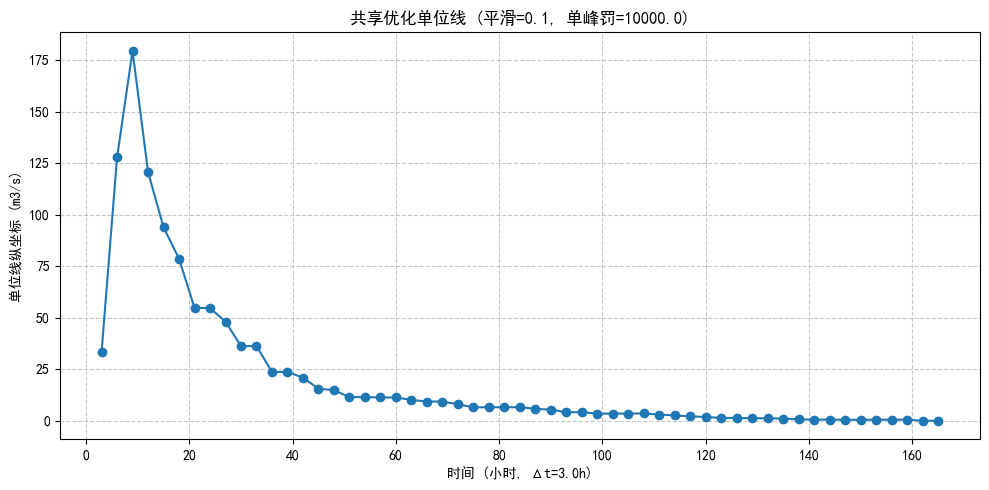


--- 所有洪水事件的误差分析 (使用单一共享单位线，按NSE排序) ---
文件名          NSE       洪量相误(%) 洪峰相误(%)
20000710.csv -795.8958 2467.09 1450.72
20030822.csv -113.4764  566.34  652.46
20140721.csv  -95.6508 1192.06  520.19
20090713.csv  -91.0069  846.86  799.90
20020722.csv  -48.8314  493.94  370.34
19890717.csv  -47.8901  204.15  601.56
20160631.csv   -6.3311  201.10  206.81
19900706.csv   -4.8143   76.32  159.95
20150802.csv   -2.3466  167.40  112.20
19990730.csv   -1.5109  121.65   50.85
20100819.csv   -1.1607   25.05   33.21
20060730.csv   -0.6580   74.38    7.46
19930724.csv   -0.3897   21.39   31.85
20170802.csv   -0.3873  129.12   24.83
20130701.csv   -0.3106   45.86   32.76
19880816.csv   -0.1756   25.05   59.71
20080731.csv    0.3624    2.29    7.88
20070811.csv    0.5494   16.14   17.58
19860731.csv    0.5805   17.79   33.07
19920901.csv    0.5823   52.29   15.97
19850818.csv    0.5836   36.11   57.74
20050808.csv    0.6164   22.10    6.30
19950817.csv    0.6281   18.38    5.67
19960729.csv    0.6916  

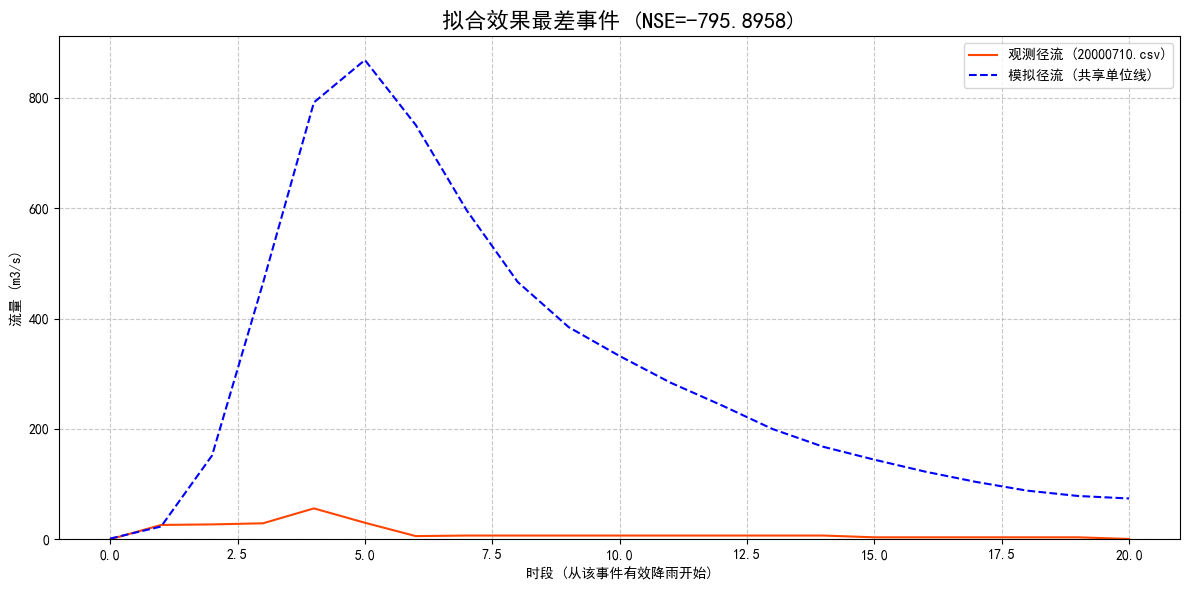

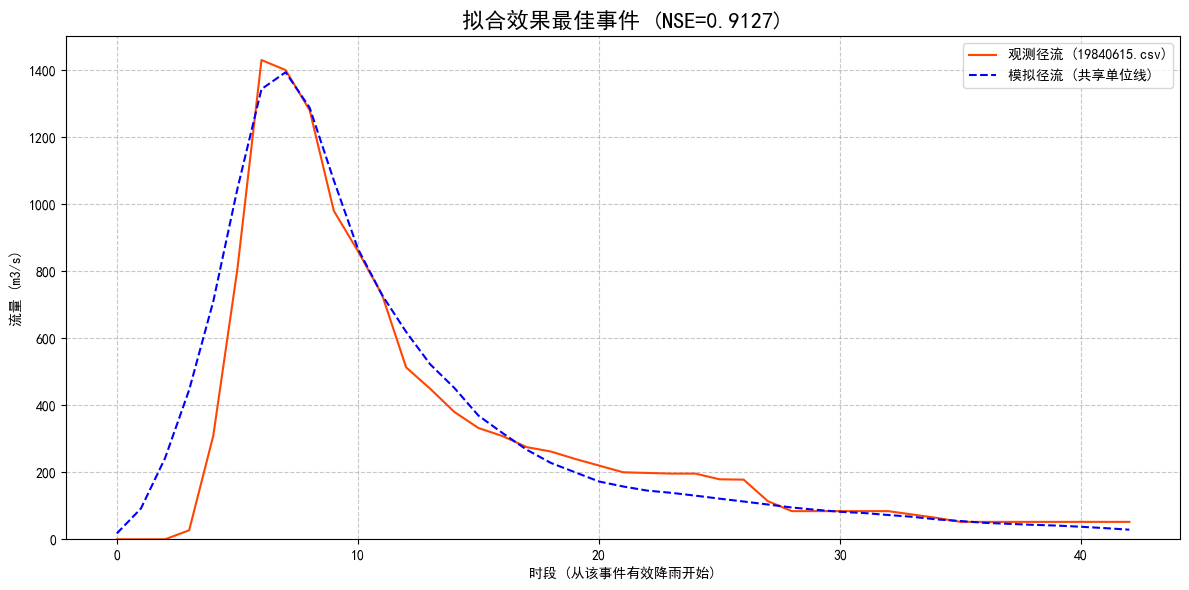


--- 整体统计 ---
所有有效事件的平均NSE: -31.4451
有效NSE 中位数: 0.5814


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.font_manager import FontProperties
import os

# --- 配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("中文字体 SimHei 未找到，请确保已安装或修改字体设置。")

R_UH = 10.0
DELTA_T_HOURS = 3.0
delta_t_seconds = DELTA_T_HOURS * 3600.0

# --- 辅助函数：数据预处理 (与之前相同) ---
def preprocess_single_event_data(csv_filepath):
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None
        for enc in encodings_to_try:
            try:
                df = pd.read_csv(csv_filepath, encoding=enc)
                break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None

    time_col = '时间'
    net_rain_col = '泰森多边形面雨量'
    direct_runoff_col = '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None

    df[net_rain_col] = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0)
    df[direct_runoff_col] = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0)
    net_rain_full_event = df[net_rain_col].values
    direct_runoff_obs_full_event = df[direct_runoff_col].values

    first_rain_idx, has_effective_rain = 0, False
    for i, r_val in enumerate(net_rain_full_event):
        if r_val > 1e-6: first_rain_idx, has_effective_rain = i, True; break
    if not has_effective_rain: return None

    last_rain_idx = len(net_rain_full_event) - 1
    for i in range(len(net_rain_full_event) - 1, first_rain_idx - 1, -1):
        if net_rain_full_event[i] > 1e-6: last_rain_idx = i; break
    
    P_eff_event = net_rain_full_event[first_rain_idx : last_rain_idx + 1]
    m_eff_event = len(P_eff_event)
    if m_eff_event == 0: return None

    Q_obs_eff_event = direct_runoff_obs_full_event[first_rain_idx:]
    l_obs_eff_event = len(Q_obs_eff_event)
    n_event_specific = l_obs_eff_event - m_eff_event + 1
    if n_event_specific <= 0: return None
        
    return {
        "P_eff": P_eff_event, "Q_obs_eff": Q_obs_eff_event,
        "m_eff": m_eff_event, "l_obs_eff": l_obs_eff_event,
        "n_specific": n_event_specific, "filepath": csv_filepath,
    }

# --- 核心计算函数 (与之前相同) ---
def convolve_uh(P, U, R_UH_val):
    m_p = len(P); n_u = len(U); len_q = m_p + n_u - 1
    if len_q < 0: len_q = 0 
    Q_sim = np.zeros(len_q)
    P_normalized = P / R_UH_val
    for i in range(m_p):
        if P_normalized[i] > 1e-9:
            for k in range(n_u):
                if (i + k) < len_q: Q_sim[i + k] += P_normalized[i] * U[k]
    return Q_sim

def objective_function_multi_event(U_params, list_of_event_data_for_opt, R_UH_val, 
                                   lambda_smooth, lambda_peak_violation, apply_peak_penalty_flag,
                                   common_n_uh):
    total_fit_loss = 0
    if len(U_params) != common_n_uh: return 1e18 
    for event_data in list_of_event_data_for_opt:
        P_event, Q_event_obs_for_opt = event_data["P_eff"], event_data["Q_obs_for_opt"]
        Q_sim_full_event = convolve_uh(P_event, U_params, R_UH_val)
        Q_sim_compare_event = Q_sim_full_event[:len(Q_event_obs_for_opt)]
        total_fit_loss += np.sum((Q_sim_compare_event - Q_event_obs_for_opt)**2)
    loss_smooth_val = 0
    if len(U_params) > 1: loss_smooth_val = np.sum(np.diff(U_params)**2)
    peak_violation_penalty_val = 0
    if apply_peak_penalty_flag and len(U_params) > 2:
        actual_k_peak = np.argmax(U_params)
        for j in range(actual_k_peak):
            if U_params[j+1] < U_params[j] - 1e-6: peak_violation_penalty_val += (U_params[j] - U_params[j+1])**2
        for j in range(actual_k_peak, len(U_params) - 1):
            if U_params[j+1] > U_params[j] + 1e-6: peak_violation_penalty_val += (U_params[j+1] - U_params[j])**2
    return total_fit_loss + lambda_smooth * loss_smooth_val + lambda_peak_violation * peak_violation_penalty_val

# --- 新增的绘图辅助函数 ---
def plot_fit_comparison(event_data, U_optimized, plot_title):
    """
    为指定的洪水事件绘制观测与模拟径流的对比图。
    """
    P_event = event_data["P_eff"]
    Q_obs_event = event_data["Q_obs_eff"]
    event_filename = os.path.basename(event_data["filepath"])
    
    Q_sim_full = convolve_uh(P_event, U_optimized, R_UH)
    Q_sim_plot = Q_sim_full[:len(Q_obs_event)]

    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(Q_obs_event)), Q_obs_event, label=f'观测径流 ({event_filename})', color='orangered', linestyle='-')
    plt.plot(np.arange(len(Q_sim_plot)), Q_sim_plot, label='模拟径流 (共享单位线)', color='blue', linestyle='--')
    plt.title(plot_title, fontsize=16)
    plt.xlabel('时段 (从该事件有效降雨开始)')
    plt.ylabel('流量 (m3/s)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()


# --- 主程序 ---
# 1. 数据预处理
data_folder = "data_source/" 
csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
print(f"找到 {len(csv_files)} 个CSV文件，将进行处理...")

all_events_processed_data = []
for csv_file in csv_files:
    event_data = preprocess_single_event_data(csv_file)
    if event_data: all_events_processed_data.append(event_data)

if not all_events_processed_data:
    print("没有成功处理任何洪水事件数据。程序退出。")
    exit()
print(f"成功预处理 {len(all_events_processed_data)} 场洪水事件。")

# 2. 确定共享单位线长度
n_specific_values = [data["n_specific"] for data in all_events_processed_data if data["n_specific"] > 0]
if not n_specific_values:
    print("错误：所有已处理事件的n_specific均不大于0。")
    exit()

common_n_uh = int(np.max(n_specific_values))
if common_n_uh <= 1: common_n_uh = max(3, common_n_uh if common_n_uh > 0 else 3)
print(f"确定的共享单位线长度 common_n_uh: {common_n_uh}")

# 3. 准备优化数据集
list_of_event_data_for_opt_final = []
for event_data in all_events_processed_data:
    P_eff, Q_obs_eff, m_eff = event_data["P_eff"], event_data["Q_obs_eff"], event_data["m_eff"]
    target_q_len_event = m_eff + common_n_uh - 1
    if target_q_len_event < 0: target_q_len_event = 0
    Q_obs_for_opt_event = np.zeros(target_q_len_event)
    len_to_copy = min(len(Q_obs_eff), target_q_len_event)
    Q_obs_for_opt_event[:len_to_copy] = Q_obs_eff[:len_to_copy]
    list_of_event_data_for_opt_final.append({"P_eff": P_eff, "Q_obs_for_opt": Q_obs_for_opt_event, "filepath": event_data["filepath"]})

# 4. 设置优化参数并执行
U_initial_guess = np.zeros(common_n_uh)
bounds = [(0, None) for _ in range(common_n_uh)] 

smoothing_factor = 0.1
peak_violation_weight = 10000.0
apply_peak_penalty_in_opt = common_n_uh > 2

print(f"\n开始使用 {len(list_of_event_data_for_opt_final)} 场洪水数据优化共享单位线...")
print(f"平滑因子: {smoothing_factor}, 单峰惩罚因子: {peak_violation_weight if apply_peak_penalty_in_opt else 'N/A'}")

result_shared_uh = minimize(
    objective_function_multi_event, U_initial_guess,
    args=(list_of_event_data_for_opt_final, R_UH, smoothing_factor, peak_violation_weight, apply_peak_penalty_in_opt, common_n_uh),
    method='L-BFGS-B', bounds=bounds, options={'disp': True, 'maxiter': 500, 'ftol': 1e-9, 'gtol': 1e-7}
)

U_optimized_shared = result_shared_uh.x if (result_shared_uh.success or result_shared_uh.status in [0,2]) else U_initial_guess
print("\n共享单位线优化完成！")

# 5. 绘制共享单位线
time_axis_uh_shared = np.arange(1, common_n_uh + 1) * DELTA_T_HOURS
plt.figure(figsize=(10, 5))
plt.plot(time_axis_uh_shared, U_optimized_shared, marker='o', linestyle='-')
plt.title(f'共享优化单位线 (平滑={smoothing_factor}, 单峰罚={peak_violation_weight if apply_peak_penalty_in_opt else "N/A"})')
plt.xlabel(f'时间 (小时, Δt={DELTA_T_HOURS}h)')
plt.ylabel('单位线纵坐标 (m3/s)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 6. 详细评估共享单位线在所有事件上的表现
all_event_analysis_results = []
for event_data in all_events_processed_data:
    P_event, Q_obs_event_full = event_data["P_eff"], event_data["Q_obs_eff"]
    event_filename = os.path.basename(event_data["filepath"])
    Q_sim_event_full = convolve_uh(P_event, U_optimized_shared, R_UH)
    Q_sim_event_compare = Q_sim_event_full[:len(Q_obs_event_full)]
    
    current_event_analysis = {
        "文件名": event_filename, "NSE": np.nan, 
        "洪量相误(%)": np.nan, "洪峰相误(%)": np.nan,
        "filepath": event_data["filepath"] # 保存完整路径用于查找
    }
    
    if len(Q_obs_event_full) > 0 and len(Q_sim_event_compare) == len(Q_obs_event_full):
        mean_obs = np.mean(Q_obs_event_full)
        den_nse = np.sum((Q_obs_event_full - mean_obs)**2)
        if den_nse == 0: 
            nse = 1.0 if np.allclose(Q_sim_event_compare, Q_obs_event_full) else -np.inf
        else: 
            nse = 1 - (np.sum((Q_obs_event_full - Q_sim_event_compare)**2) / den_nse)
        current_event_analysis["NSE"] = nse

        vol_obs = np.sum(Q_obs_event_full) * delta_t_seconds
        vol_sim = np.sum(Q_sim_event_compare) * delta_t_seconds
        if vol_obs > 1e-6: current_event_analysis["洪量相误(%)"] = (np.abs(vol_sim - vol_obs) / vol_obs) * 100.0
        peak_obs = np.max(Q_obs_event_full)
        if peak_obs > 1e-6: current_event_analysis["洪峰相误(%)"] = (np.abs(np.max(Q_sim_event_compare) - peak_obs) / peak_obs) * 100.0
            
    all_event_analysis_results.append(current_event_analysis)

# --- 使用 pandas DataFrame 来排序和打印所有结果 ---
results_df = pd.DataFrame(all_event_analysis_results)
results_df_sorted = results_df.sort_values(by="NSE", ascending=True, na_position='first').reset_index(drop=True)

# 设置 pandas 的显示选项，以确保所有行都会被打印出来
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', 1000)      
pd.set_option('display.colheader_justify', 'left') 

print("\n--- 所有洪水事件的误差分析 (使用单一共享单位线，按NSE排序) ---")
formatted_df = results_df_sorted.copy().drop(columns=['filepath']) # 打印时去掉filepath列
formatted_df['NSE'] = formatted_df['NSE'].map(lambda x: f'{x:.4f}' if pd.notna(x) and np.isfinite(x) else ('-Inf' if x == -np.inf else 'N/A'))
formatted_df['洪量相误(%)'] = formatted_df['洪量相误(%)'].map(lambda x: f'{x:.2f}' if pd.notna(x) else 'N/A')
formatted_df['洪峰相误(%)'] = formatted_df['洪峰相误(%)'].map(lambda x: f'{x:.2f}' if pd.notna(x) else 'N/A')
print(formatted_df.to_string(index=False))
pd.reset_option('display.max_rows')

# --- 新增：绘制NSE最高和最低场次的拟合曲线 ---
valid_results_for_plot = [res for res in all_event_analysis_results if pd.notna(res["NSE"]) and np.isfinite(res["NSE"])]
if len(valid_results_for_plot) > 0:
    # 找到NSE最低的事件
    worst_fit_event_info = min(valid_results_for_plot, key=lambda x: x['NSE'])
    worst_fit_filepath = worst_fit_event_info['filepath']
    worst_fit_nse = worst_fit_event_info['NSE']
    worst_event_data = next((data for data in all_events_processed_data if data["filepath"] == worst_fit_filepath), None)
    if worst_event_data:
        plot_fit_comparison(worst_event_data, U_optimized_shared, f'拟合效果最差事件 (NSE={worst_fit_nse:.4f})')
    
    # 找到NSE最高的事件
    best_fit_event_info = max(valid_results_for_plot, key=lambda x: x['NSE'])
    best_fit_filepath = best_fit_event_info['filepath']
    best_fit_nse = best_fit_event_info['NSE']
    best_event_data = next((data for data in all_events_processed_data if data["filepath"] == best_fit_filepath), None)
    if best_event_data:
        plot_fit_comparison(best_event_data, U_optimized_shared, f'拟合效果最佳事件 (NSE={best_fit_nse:.4f})')

# --- 整体统计 ---
valid_nse_values = [res["NSE"] for res in all_event_analysis_results if pd.notna(res["NSE"]) and np.isfinite(res["NSE"])]
if valid_nse_values:
    print(f"\n--- 整体统计 ---")
    print(f"所有有效事件的平均NSE: {np.mean(valid_nse_values):.4f}")
    print(f"有效NSE 中位数: {np.median(valid_nse_values):.4f}")